2022-12-20 15:45:31.958674: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(43800, 8)
(43797, 32)
After train-test split:
train_X: (8760, 24) , train_y: (8760,)
test_X: (35037, 24) , test_y: (35037,)
After reshape:
train_X: (8760, 3, 8) , train_y: (8760,)
test_X: (35037, 3, 8) , test_y: (35037,)
Epoch 1/50
122/122 - 3s - loss: 0.0522 - val_loss: 0.0423 - 3s/epoch - 21ms/step
Epoch 2/50
122/122 - 1s - loss: 0.0248 - val_loss: 0.0255 - 866ms/epoch - 7ms/step
Epoch 3/50
122/122 - 1s - loss: 0.0210 - val_loss: 0.0209 - 856ms/epoch - 7ms/step
Epoch 4/50
122/122 - 1s - loss: 0.0208 - val_loss: 0.0197 - 854ms/epoch - 7ms/step
Epoch 5/50
122/122 - 1s - loss: 0.0203 - val_loss: 0.0201 - 857ms/epoch - 7ms/step
Epoch 6/50
122/122 - 1s - loss: 0.0202 - val_loss: 0.0193 - 872ms/epoch - 7ms/step
Epoch 7/50
122/122 - 1s - loss: 0.0193 - val_loss: 0.0189 - 855ms/epoch - 7ms/step
Epoch 8/50
122/122 - 1s - loss: 0.0193 - val_loss: 0.0186 - 864ms/epoch - 7ms/step
Epoch 9/50
122/122 - 1s - loss: 0.0183 - val_loss: 0.0185 - 849ms/epoch - 7ms/step
Epoch 10/50
122/122 - 1s - loss: 

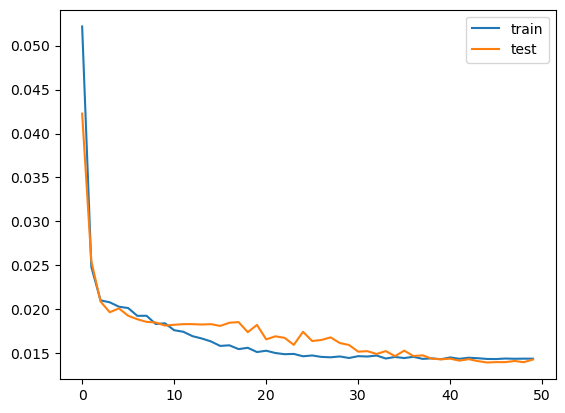

1095/1095 [==============================] - 1s 985us/step
Test RMSE: 26.743


In [1]:
import os
# Disable INFO & WARNINGS 
# due to bug with dynamic library libcudart.so.11.0 & others
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from datetime import datetime
import pandas as pd
import numpy as np

from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## Load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = pd.read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print('After train-test split:')
print('train_X:', train_X.shape, ', train_y:', train_y.shape)
print('test_X:', test_X.shape, ', test_y:',test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print('After reshape:')
print('train_X:', train_X.shape, ', train_y:', train_y.shape)
print('test_X:', test_X.shape, ', test_y:',test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)